<a href="https://colab.research.google.com/github/211fa07077/MACHINE-LEARNING-MODELS/blob/main/pest_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import tempfile


# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Resizing,Rescaling,InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB4
import tensorflow_probability as tfp
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast



# System libraries

from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix


##Data Loading

In [ ]:
data='/content/drive/MyDrive/pests'
class_name=["ants",'bees','beetle','catterpillar','earthworms','earwig','grasshopper','moth','slug','snail','wasp','weevil']

In [ ]:
configuration={'batchsize':32,'img_size':256,
               'learningrate':0.001,
               'n_epoches':10,
               "num_classes":12,
               'droupoutrate':0.0,
               'regularization_rate':0.0 ,
               'num_filters':6,
               "kernelsize":3,
               "n_strides":1,
               'poolsize':2,
               'N_DENSE_1':100,
               'N_DENSE_2':10,
}

In [ ]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(data)


In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


In [ ]:
def save_images_from_df(image_df, output_dir):
    for index, row in image_df.iterrows():
        filepath = row['Filepath']
        label = row['Label']

        image = cv2.imread(filepath)
        output_subdir = os.path.join(output_dir, label)
        os.makedirs(output_subdir, exist_ok=True)

        output_filepath = os.path.join(output_subdir, os.path.basename(filepath))
        cv2.imwrite(output_filepath, image)

# Provide the DataFrame and the output directory
train_data='train '
train_data = save_images_from_df(train_df, train_data)  # Change this to your desired output directory

test_directory = 'test'
save_images_from_df(test_df, test_directory )

In [ ]:
train_data='/content/drive/MyDrive/pests'

In [ ]:
test_data='/content/drive/MyDrive/pests'

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=configuration['batchsize'],
    image_size=(configuration['img_size'], configuration['img_size']),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='training',     # Create a dataset for the training subset
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=configuration['batchsize'],
    image_size=(configuration['img_size'], configuration['img_size']),
    shuffle=True,
    seed=99,
    validation_split=0.15,  # Use 20% of the data for validation
    subset='validation',   # Create a dataset for the validation subset
)


Found 2444 files belonging to 12 classes.
Using 1956 files for training.
Found 2444 files belonging to 12 classes.
Using 366 files for validation.


In [ ]:

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=configuration['batchsize'],
    image_size=(configuration['img_size'], configuration['img_size']),
    shuffle=True,
    seed=99,
)


Found 2444 files belonging to 12 classes.


##Data Visualization

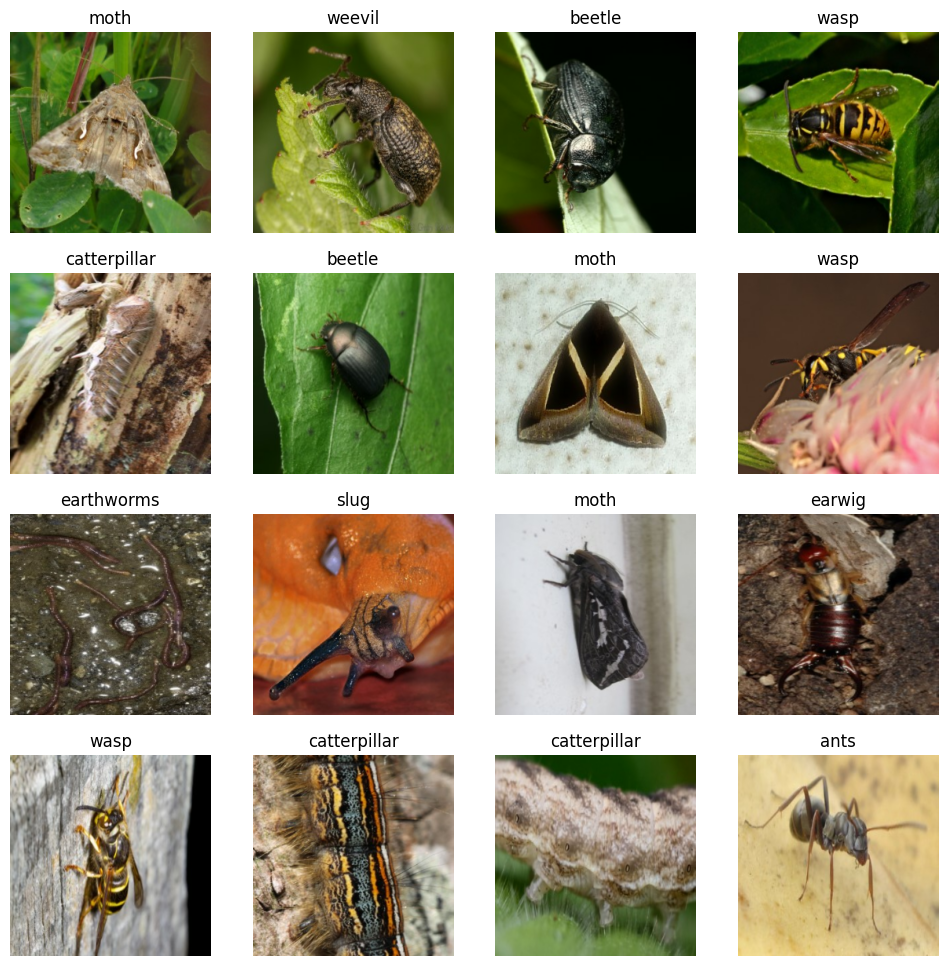

In [ ]:
plt.figure(figsize=(12,12))
for   images,labels in  train_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)
   plt.imshow(images[i]/255.)
   plt.title(class_name[tf.argmax(labels[i],axis=0).numpy()])
   plt.axis("off")


In [ ]:
vali_dataset=(
   val_dataset
    .prefetch(tf.data.AUTOTUNE)


)

In [ ]:
resize_rescale=tf.keras.Sequential(
    Resizing(configuration['img_size'],configuration['img_size']),
    Rescaling(1./255)
)

##Model

In [ ]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB4(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(configuration["img_size"], configuration["img_size"], 3)),


   pretrained_model,
    BatchNormalization(),
    Dense(configuration["N_DENSE_1"], activation="relu",
          kernel_regularizer=L2(configuration['regularization_rate'])),
    BatchNormalization(),
      Dense(configuration["N_DENSE_2"], activation="relu",
          kernel_regularizer=L2(configuration['regularization_rate'])),
     BatchNormalization(),
      Dense(configuration["num_classes"], activation="softmax" )

])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 batch_normalization (BatchN  (None, 1792)             7168      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               179300    
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 batch_normalization_2 (Batc  (None, 10)               4

##Loss

In [ ]:
loss_funcion=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,

)

In [ ]:

metrics=[CategoricalAccuracy(name= 'accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [ ]:
lenet_model.compile(
    optimizer=Adam(learning_rate=configuration['learningrate']),
                   loss=loss_funcion,
                   metrics=metrics

)

In [ ]:
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

##Data Augumentation

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25, 0.2501)),
   RandomFlip("horizontal_and_vertical",seed=42),  # Specify a seed for reproducibility
])


In [ ]:

def process_data(image, label):
    # Apply augmentation layers to the image

  augmented_image=augment_layers(image)
    # Resize the augmented image
  resized_image = tf.image.resize(augmented_image, size=(configuration["img_size"], configuration["img_size"]))

  return resized_image, label

# Apply augmentation and preprocessing to the dataset
training_dataset = (
    train_dataset.
    shuffle(1000)
    .map(partial(process_data),num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

)


##Cutmix

In [ ]:
IM_SIZE=256
def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(8, IM_SIZE - 8).sample(1)[0], dtype=tf.int32)

    r_w = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
    r_h = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)

    r_x = tf.clip_by_value(r_x, r_w // 2,configuration['img_size'] - r_w // 2)
    r_y = tf.clip_by_value(r_y, r_h // 2, configuration['img_size'] - r_h // 2)

    x_b_r = tf.clip_by_value(r_x + r_w // 2, 0, configuration['img_size'])
    y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, configuration['img_size'])

    r_w = x_b_r - r_x
    if r_w == 0:
        r_w = 1

    r_h = y_b_r - r_y
    if r_h == 0:
        r_h = 1

    return r_y, r_x, r_h, r_w


In [ ]:


def cutmix(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda_value = lamda.sample(1)[0]

    ry, rx, r_h, r_w = box(lamda_value)

    crop_2 = tf.image.crop_to_bounding_box(image_2, ry, rx, r_h, r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, ry, rx, configuration['img_size'] ,configuration['img_size'])

    crop_1 = tf.image.crop_to_bounding_box(image_1, ry, rx, r_h, r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, ry, rx, configuration['img_size'], configuration['img_size'])

    cutmixed_image = image_1 - pad_1 + pad_2


    lamda_value = tf.cast(1 - (r_w * r_h) / (configuration['img_size']*configuration['img_size']), dtype=tf.float32)

    cutmixed_label = lamda_value * tf.cast(label_1, dtype=tf.float32) + (1 - lamda_value) * tf.cast(label_2, dtype=tf.float32)

    return cutmixed_image, cutmixed_label


In [ ]:
train_dataset_1 = train_dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))


In [ ]:
cutmix_dataset = (
    mixed_dataset.
    shuffle(1000)
    .map(partial(cutmix),num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    #.batch(configuration['batchsize'])
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [ ]:
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

history = lenet_model.fit(
        training_dataset,
            epochs=configuration['n_epoches'],
            verbose=1,
            validation_data=vali_dataset
        )




Epoch 1/10
62/62 [==============================] - 54s 418ms/step - loss: 1.4351 - accuracy: 0.6621 - top_k_accuracy: 0.7689 - val_loss: 0.9597 - val_accuracy: 0.6503 - val_top_k_accuracy: 0.8825
Epoch 2/10
62/62 [==============================] - 21s 272ms/step - loss: 0.9789 - accuracy: 0.8175 - top_k_accuracy: 0.8926 - val_loss: 0.6169 - val_accuracy: 0.8962 - val_top_k_accuracy: 0.9454
Epoch 3/10
62/62 [==============================] - 23s 315ms/step - loss: 0.7610 - accuracy: 0.8635 - top_k_accuracy: 0.9202 - val_loss: 0.4775 - val_accuracy: 0.9344 - val_top_k_accuracy: 0.9672
Epoch 4/10
62/62 [==============================] - 21s 271ms/step - loss: 0.5934 - accuracy: 0.8931 - top_k_accuracy: 0.9407 - val_loss: 0.3845 - val_accuracy: 0.9399 - val_top_k_accuracy: 0.9672
Epoch 5/10
62/62 [==============================] - 23s 277ms/step - loss: 0.5038 - accuracy: 0.9090 - top_k_accuracy: 0.9571 - val_loss: 0.3394 - val_accuracy: 0.9454 - val_top_k_accuracy: 0.9672
Epoch 6/10
62/6

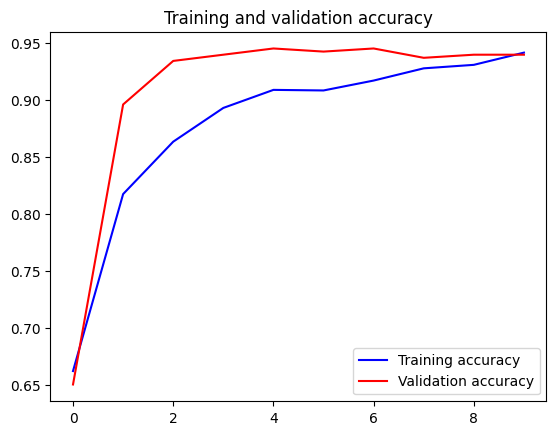

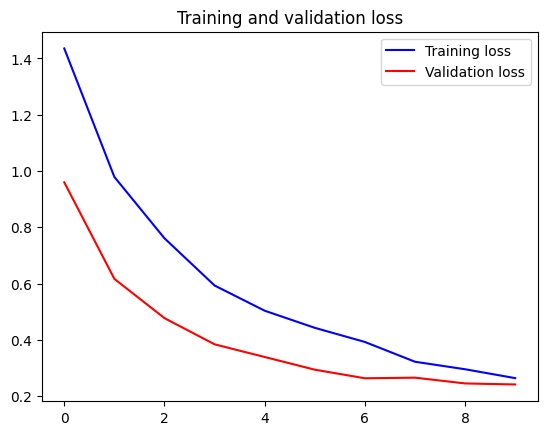

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Predict the label of the test_images
pred = lenet_model.predict(test_dataset)


77/77 [==============================] - 18s 190ms/step


In [ ]:

lenet_model.evaluate(test_dataset)

77/77 [==============================] - 15s 185ms/step - loss: 0.1481 - accuracy: 0.9677 - top_k_accuracy: 0.9857


[0.1480569988489151, 0.9676759243011475, 0.9856792092323303]

In [ ]:
predicted=[]
labels=[]
for im, label in test_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [ ]:
pred= np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab= np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

[[232   0   1   0   0   0   1   0   0   0   0   1]
 [  0 194   0   0   0   1   0   0   0   0   0   0]
 [  0   2 157   2   1   6   1   0   0   0   1   8]
 [  0   3   0 167   7   0   1   0   1   1   2   0]
 [  0   0   0   0 123   0   0   0   4   0   0   0]
 [  1   4   1   1   0 155   2   1   1   0   0   0]
 [  0   1   0   2   0   2 209   0   0   0   0   0]
 [  0   0   0   0   0   1   0 229   0   0   1   0]
 [  0   0   0   1   3   0   0   1 170   1   0   0]
 [  0   0   0   0   0   0   0   0   0 237   0   0]
 [  0   8   0   0   0   0   1   0   0   0 232   0]
 [  2   0   0   0   0   0   0   0   0   0   0 260]]


Text(0.5, 58.7222222222222, 'Predicted')

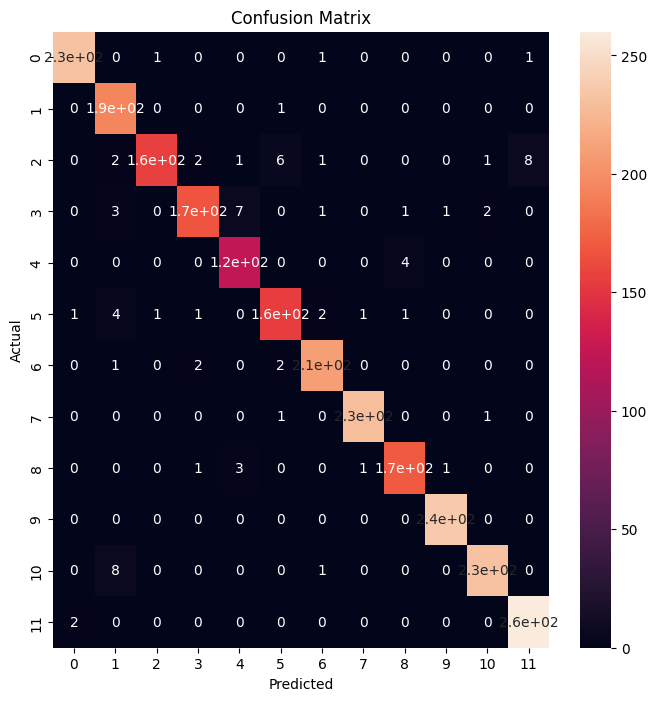

In [ ]:
cm=confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")

#Visualizing

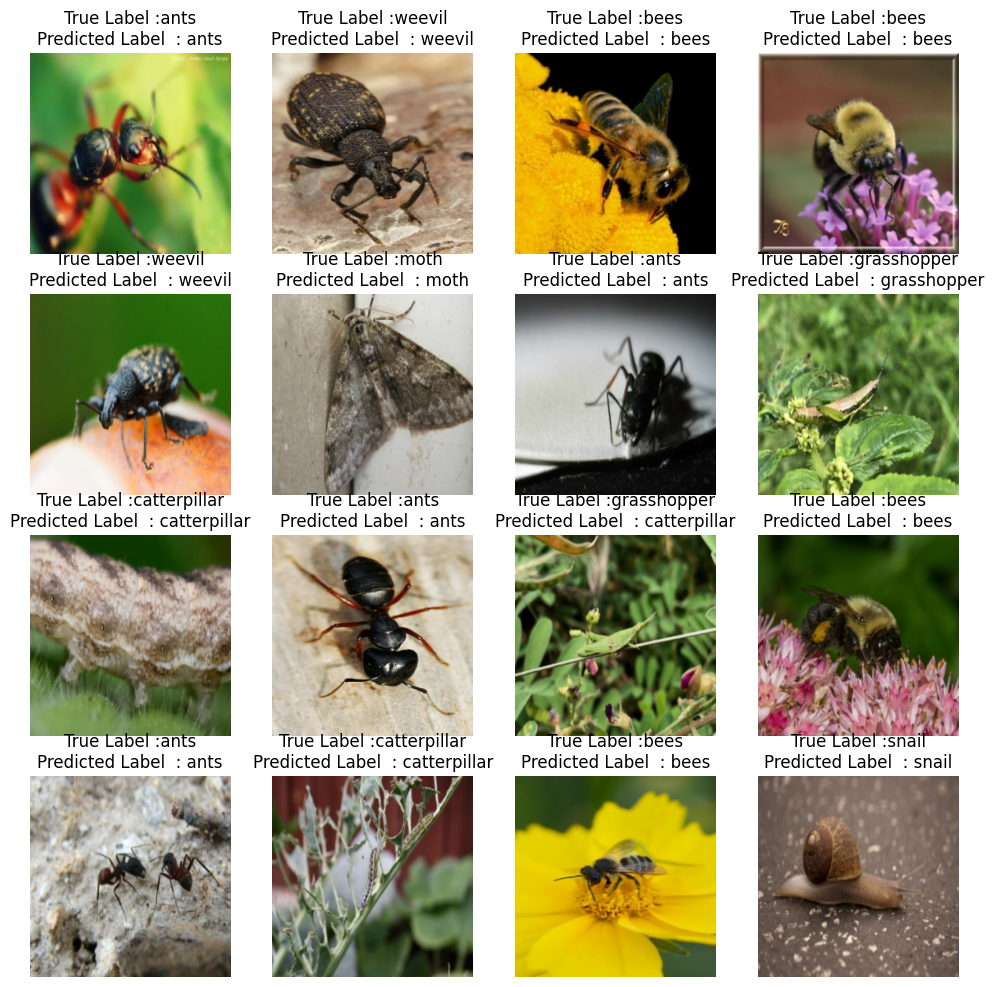

In [ ]:
plt.figure(figsize=(12,12))
for   images,labels in  test_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)

   plt.imshow(images[i]/255.)
   plt.title("True Label :"+ class_name[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted Label  : " + class_name[tf.argmax(lenet_model(tf.expand_dims(images[i],axis=0)),axis= -1).numpy()[0]])
   plt.axis("off")